# Stock Prediction

We are using historical data from yahoo's finance api's to predict the stock prick for a given stock symbol, given other stock symbols. In addition to the normal pandas and numpy libraries, We are also using Prophet (https://facebook.github.io/prophet/docs/quick_start.html), which is a forecasting library released by the Facebook core datascience team. It implements a procedure for forecasting trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.


In [1]:
# !conda install -c conda-forge fbprophet -y
# !pip install --upgrade plotly
# !pip install yfinance



import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline

    Now we load the data. We can specify the start and end dates and also the stock symbol.

In [2]:
import pandas_datareader.data as web
import datetime
import numpy as np
import yfinance as yf

# change this to your desired stock symbol to get results
stockSymbol = 'SBIN.NS'
# Considering data from 2000 to 2022
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2022, 1, 21)

# we now get data for that stock symbol from yahoo finance api
df = yf.download( stockSymbol, start , end)
print(df.head())

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-01-04  227.500000  230.000000  227.500000  229.119995  202.633789   
2010-01-05  230.800003  231.000000  228.009995  229.205002  202.708954   
2010-01-06  229.699997  231.500000  228.500000  230.580002  203.925018   
2010-01-07  230.600006  231.000000  228.110001  229.289993  202.784134   
2010-01-08  229.399994  230.389999  228.009995  228.604996  202.178299   

              Volume  
Date                  
2010-01-04  11031470  
2010-01-05  11613740  
2010-01-06  14527930  
2010-01-07   8576510  
2010-01-08  10453820  


In [3]:
# Now we can get an array of only the closing values and plot the data
close = df['Close']

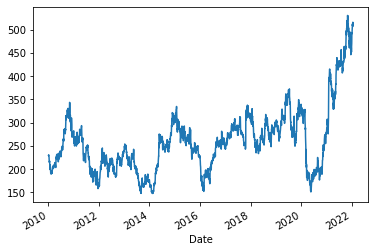

In [4]:
#Plotting the data
close.plot();

In [5]:
# We now reformat the data frame to have columns 'ds' and 'y' with the dates and values respectively which is needed
# by prophet. We also take the log of the values to get more managable values
close_df = close.reset_index().rename(columns={'Date':'ds', 'Close':'y'})
close_df['y'] = np.log(close_df['y'])

In [6]:
# Now we create the prophet model with daily seasonality to be true
model = Prophet(daily_seasonality=True)
model.fit(close_df)
# 5* 365 = 1825.Forecasting for 5 years from now. 
future = model.make_future_dataframe(periods=1825) 
forecast = model.predict(future)
print(forecast)

Initial log joint probability = -7.72025
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8938.67     0.0228363       4333.89           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9198.27    0.00285582       576.346           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        9325.2     0.0325898       6725.88           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9370.77    0.00189811       1164.35           1           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9385.72     0.0023706        718.37           1           1      578   
    Iter      log prob        ||dx||      ||grad||       alpha  

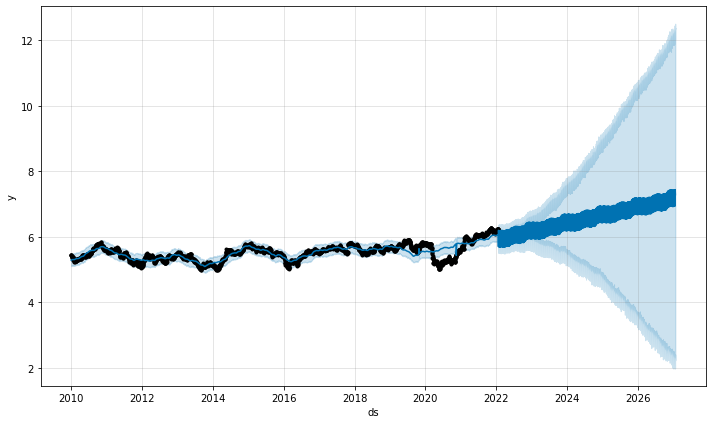

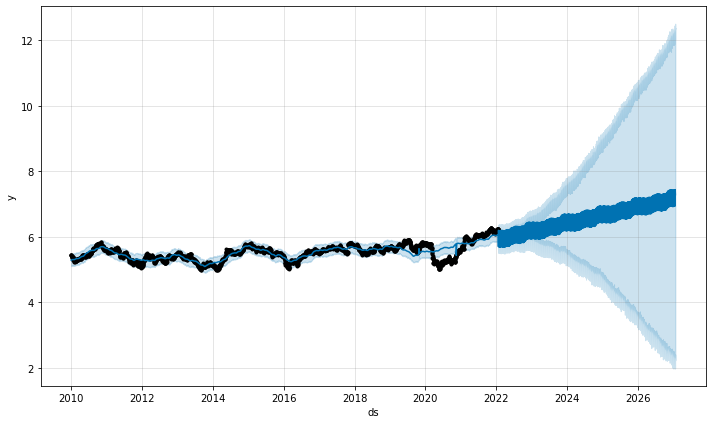

In [7]:
model.plot(forecast)

# We can now do a performance evaluation of the result obtained from this.

In [8]:
# to do an evaluation, we join the dataframe df with the forecast obtained. We transform it by dropping na and just taking 
# the yhat, upper, lower and close values.
data = forecast.set_index('ds').join(df)
data = data[['Close', 'yhat', 'yhat_upper', 'yhat_lower' ]].dropna().tail(500)
data['yhat']=np.exp(data.yhat)
data['yhat_upper']=np.exp(data.yhat_upper)
data['yhat_lower']=np.exp(data.yhat_lower)

In [9]:
data

,Close,yhat,yhat_upper,yhat_lower
ds,,,,
2020-01-20,314.000000,260.325985,317.383702,218.876481
2020-01-21,313.700012,259.658485,309.452635,213.600074
2020-01-22,316.149994,259.324793,312.005305,214.693610
2020-01-23,323.200012,259.460044,311.526881,215.322569
2020-01-24,324.049988,259.124641,307.731607,216.005292
...,...,...,...,...
2022-01-14,508.350006,427.446413,514.576766,355.249819
2022-01-17,514.000000,427.490107,516.920345,354.725486
2022-01-18,506.799988,426.560143,513.883621,354.088502


<AxesSubplot:xlabel='ds'>

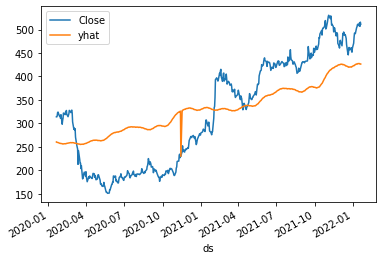

In [10]:
# we can now plot the actual values with predicted ones
data[['Close', 'yhat']].plot()


# Average errors is as below

In [48]:
AE = (data.yhat - data.Close)
print(AE.describe())

count    500.000000
mean      -1.255792
std       31.812232
min     -100.616987
25%      -16.470317
50%        1.334983
75%       10.789524
max      119.173990
dtype: float64


# The R2 score , Mean squared error and Mean absolute error is asbelow

In [49]:
r2_score(data.Close, data.yhat)


0.8613139983370754

In [50]:
mean_squared_error(data.Close, data.yhat)

1011.5710595526581

In [51]:
mean_absolute_error(data.Close, data.yhat)

22.395376137336456

# Forecasting with y upper and y lower confidence

Text(0.5, 0, 'Date')

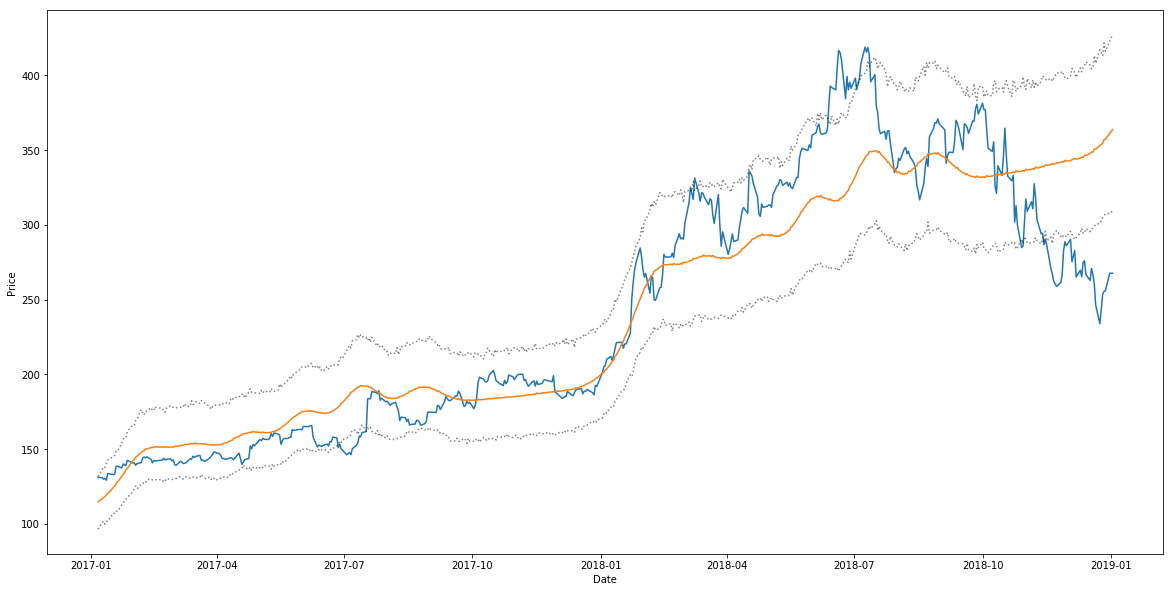

In [52]:
plt.rcParams['figure.figsize']=(20,10)
fig, ax1 = plt.subplots()
ax1.plot(data.Close)
ax1.plot(data.yhat)
ax1.plot(data.yhat_upper, color='black',  linestyle=':', alpha=0.5)
ax1.plot(data.yhat_lower, color='black',  linestyle=':', alpha=0.5)
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')

In [9]:
import pickle

# read the Prophet model object
with open('./../../resources/fbprophet/model/AARTIIND.NS.pkl', 'rb') as f:
    m = pickle.load(f)

selected_stock = 'SBIN.NS'

In [11]:
with open('./../../resources/fbprophet/model/'+ selected_stock+'.pkl', 'rb') as f:
    m = pickle.load(f)
future = m.make_future_dataframe(periods=10)
forecast = m.predict(future)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2980,2022-01-26,7.375998,7.276975,7.448330,7.375998,7.375998,-0.014106,-0.014106,-0.014106,0.006647,...,-0.019100,-0.019100,-0.019100,-0.001653,-0.001653,-0.001653,0.0,0.0,0.0,7.361892
2981,2022-01-27,7.376445,7.280961,7.451429,7.376445,7.376445,-0.012680,-0.012680,-0.012680,0.006647,...,-0.016905,-0.016905,-0.016905,-0.002423,-0.002423,-0.002423,0.0,0.0,0.0,7.363765
2982,2022-01-28,7.376893,7.275881,7.446600,7.376893,7.376893,-0.013153,-0.013153,-0.013153,0.006647,...,-0.016674,-0.016674,-0.016674,-0.003126,-0.003126,-0.003126,0.0,0.0,0.0,7.363740
2983,2022-01-29,7.377340,7.312842,7.470937,7.377340,7.377340,0.017263,0.017263,0.017263,0.006647,...,0.014368,0.014368,0.014368,-0.003752,-0.003752,-0.003752,0.0,0.0,0.0,7.394603
2984,2022-01-30,7.377787,7.375164,7.540358,7.377787,7.377787,0.078851,0.078851,0.078851,0.006647,...,0.076495,0.076495,0.076495,-0.004291,-0.004291,-0.004291,0.0,0.0,0.0,7.456639


In [8]:
Step 1: Uninstall pystan

pip uninstall pystan
Step 2: Install pystan version ~2.14

pip install pystan~=2.14
**Step 3: Try installing fbprophet again **

pip install fbprophet



  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  ERROR: Command errored out with exit status 1:
   command: /Users/arungupta/opt/anaconda3/bin/python -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/xm/04s2ld0n1jqbwfgytc7tjrf00000gn/T/pip-install-f8e9b71w/fbprophet_56f7b4e365de46ae9516b4eddb62dc43/setup.py'"'"'; __file__='"'"'/private/var/folders/xm/04s2ld0n1jqbwfgytc7tjrf00000gn/T/pip-install-f8e9b71w/fbprophet_56f7b4e365de46ae9516b4eddb62dc43/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/xm/04s2ld0n1jqbwfgytc7tjrf00000gn/T/pip-wheel-idz4gh84
       cwd: /private/var/folders/xm/04s2ld0n1jqbwfgytc7tjrf00000gn/T/pip-install-f8e9b71w/fbprophet_56f7b4e365de46ae9516b4eddb62dc43/
  Complete out

In [3]:
from datetime import date
import yfinance as yf
import pandas as pd
import numpy as np
from fbprophet import Prophet
from pathlib import Path
import pickle


# Considering data from 2000 to 2022
start = datetime.datetime(2018, 1, 1)
end = date.today().strftime("%Y-%m-%d")

stocks = Path('./../../resources/stock_list.txt').read_text().split("\n")
index=1
for s in stocks:
    print(s)
    df = yf.download( s, start , end)
    close = df['Close']

    close_df = close.reset_index().rename(columns={'Date':'ds', 'Close':'y'})
    close_df['y'] = np.log(close_df['y'])
    model = Prophet(daily_seasonality=True)
    model.fit(close_df)
    pkl_path = "./../../resources/fbprophet/model/"+s+".model"
    with open(pkl_path, "wb") as f:
        pickle.dump(model, f)

#     # save the dataframe
#     forecast.to_pickle("./../../resources/fbprophet/forecast/"+s+".forecast")
    print(index,"*** Data Saved for -> ",s)
    index = index+1



AARTIIND.NS
[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.24663
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4323.95     0.0113623        6553.1           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        4369.5    0.00180872       858.969           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4376.54    0.00969944       725.494           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4382.68     0.0103118       3272.72           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4389.17   0.000856503       1488.82      0.8265      0.

In [63]:
selected_stock = 'ZEEL.NS'
model_file_path = './../../resources/fbprophet/model/'+ selected_stock+'.model'

# read the Prophet model object
with open(pkl_path, 'rb') as f:
    m = pickle.load(f)

future = m.make_future_dataframe(periods=10)
forecast = m.predict(future)


In [64]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2981,2022-01-27,5.316671,5.261297,5.575315,5.316671,5.316671,0.101561,0.101561,0.101561,0.051584,...,0.033563,0.033563,0.033563,0.016414,0.016414,0.016414,0.0,0.0,0.0,5.418232
2982,2022-01-28,5.316617,5.253724,5.566573,5.316617,5.316617,0.094613,0.094613,0.094613,0.051584,...,0.030270,0.030270,0.030270,0.012758,0.012758,0.012758,0.0,0.0,0.0,5.411230
2983,2022-01-29,5.316563,5.035175,5.350801,5.316563,5.316563,-0.123513,-0.123513,-0.123513,0.051584,...,-0.184203,-0.184203,-0.184203,0.009106,0.009106,0.009106,0.0,0.0,0.0,5.193050
2984,2022-01-30,5.316509,5.245233,5.567911,5.316509,5.316509,0.090000,0.090000,0.090000,0.051584,...,0.032918,0.032918,0.032918,0.005497,0.005497,0.005497,0.0,0.0,0.0,5.406509
2985,2022-01-31,5.316456,5.226923,5.563859,5.316456,5.316456,0.081794,0.081794,0.081794,0.051584,...,0.028236,0.028236,0.028236,0.001974,0.001974,0.001974,0.0,0.0,0.0,5.398249


In [65]:
df = yf.download( selected_stock, start , end)


[*********************100%***********************]  1 of 1 completed


In [66]:
data = forecast.set_index('ds').join(df)
data = data[['Close', 'yhat', 'yhat_upper', 'yhat_lower' ]].dropna().tail(500)
data['yhat']=np.exp(data.yhat)
data['yhat_upper']=np.exp(data.yhat_upper)
data['yhat_lower']=np.exp(data.yhat_lower)

In [67]:
data.tail()

,Close,yhat,yhat_upper,yhat_lower
ds,,,,
2022-01-17,323.600006,231.268370,271.295518,195.748369
2022-01-18,316.600006,230.660787,272.081512,194.720207
2022-01-19,317.549988,230.892466,273.503959,194.844435
2022-01-20,308.450012,230.790378,274.011432,196.139144
2022-01-21,289.350006,229.374971,270.655476,196.078787


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-27,332.000000,333.700012,315.500000,317.950012,317.950012,22394765
2021-12-28,317.950012,325.399994,317.000000,321.500000,321.500000,14889633
2021-12-29,322.000000,324.850006,316.700012,317.950012,317.950012,10749681
2021-12-30,319.799988,321.500000,314.000000,318.100006,318.100006,13792892
2021-12-31,319.100006,323.000000,318.350006,320.799988,320.799988,7867316
2022-01-03,318.649994,324.500000,318.649994,322.950012,322.950012,5400666
2022-01-04,324.600006,329.399994,321.149994,322.350006,322.350006,8071486
2022-01-05,322.500000,322.799988,317.399994,319.049988,319.049988,5910270
2022-01-06,316.250000,325.600006,315.250000,324.549988,324.549988,8785346
